# Quality Assessment Notebook for realism of quasar templates.

To-do for this notebook:
    - compute the EMPCA for mocks and data.
    - look the difference between the first eigenvectors for mocks and data.
    - look the difference between mean spectrum for data and mocks.
    
Conclusion:
    - What parameter do we need to change in SIMQSO?

In [1]:
from __future__ import absolute_import, division, print_function

import sys, os
import numpy as np
import random
import optparse
import glob
import subprocess
import scipy as sp
import scipy.constants
from scipy import interpolate
import matplotlib.pyplot as plt
import fitsio
from astropy.io import fits

from empca import empca
from desispec.interpolation import resample_flux
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
# Lyman-alpha from eqn 5 of Calura et al. 2012 (Arxiv: 1201.5121)
# Other from eqn 1.1 of Irsic et al. 2013 , (Arxiv: 1307.3403)
# Lyman-limit from abstract of Worseck et al. 2014 (Arxiv: 1402.4154)
Lyman_series = {
    'Lya'     : { 'line':1215.67,  'A':0.0023,          'B':3.64, 'var_evol':3.8 },
    'Lyb'     : { 'line':1025.72,  'A':0.0023/5.2615,   'B':3.64, 'var_evol':3.8 },
    'Ly3'     : { 'line':972.537,  'A':0.0023/14.356,   'B':3.64, 'var_evol':3.8 },
    'Ly4'     : { 'line':949.7431, 'A':0.0023/29.85984, 'B':3.64, 'var_evol':3.8 },
    'Ly5'     : { 'line':937.8035, 'A':0.0023/53.36202, 'B':3.64, 'var_evol':3.8 },
    #'LyLimit' : { 'line':911.8,    'A':0.0023,          'B':3.64, 'var_evol':3.8 },
}

In [4]:
def transmission_Lyman(zObj,lObs):
    '''Calculate the transmitted flux fraction from the Lyman series
    This returns the transmitted flux fraction:
        1 -> everything is transmitted (medium is transparent)
        0 -> nothing is transmitted (medium is opaque)
    Args:
        zObj (float): Redshift of object
        lObs (array of float): wavelength grid
    Returns:
        array of float: transmitted flux fraction
    '''

    lRF = lObs/(1.+zObj)
    T   = sp.ones(lObs.size)

    for l in list(Lyman_series.keys()):
        w      = lRF<Lyman_series[l]['line']
        zpix   = lObs[w]/Lyman_series[l]['line']-1.
        tauEff = Lyman_series[l]['A']*(1.+zpix)**Lyman_series[l]['B']
        T[w]  *= sp.exp(-tauEff)

    return T

Open the data and only choose the QSO's. 

In [7]:
def plot_spplate(path_to_data,plate,mjd,fiber):

    ###
    path = path_to_data+str(plate)+'/spPlate-' +str(plate)+'-'+str(mjd)+'.fits'

    cat = fitsio.FITS(path)
    flux = cat[0].read()
    ivar = cat[1].read()
    end  = cat[2].read()
    h    = cat[4].read_header()
    fid = cat[5].read()
    cat.close()

    wave = h['CRVAL1'] + h['CD1_1']*sp.arange(h['NAXIS1'])
    if h['DC-FLAG']:
        wave = 10**wave

    ###
    cut = (ivar[fiber-1,:]>0.) & (end[fiber-1,:]==0)
    qsoid = np.where(fid['OBJTYPE'][:] == b'QSO             ')[0] # Here, I choose the quasars.
    if (fiber-1) in qsoid:
        bwave = wave[cut]
        bflux = flux[fiber-1,:][cut]
        bivar = ivar[fiber-1,:][cut]
    else: 
        #print('No QSO')
        bwave = np.array([0])
        bflux = np.array([0])
        bivar = np.array([0])
    return bwave, bflux, bivar

In [6]:
def lines_list(path):

    lines = []
    fileLines = open(path)
    for l in fileLines:
        l = l.split()
        if l[0]=='#': continue
        lines += [ [float(l[1]),float(l[2])] ]
    fileLines.close()
    lines = sp.asarray(lines)

    return lines

The EMPCA is coputered without subtract the mean spectrum. So, the first eigenvector likely being something similar to the mean spectrum.

In [24]:
def get_pca():

    ### Parameters
    path_spec      = '/project/projectdirs/cosmo/data/sdss/dr14/eboss/spectro/redux/v5_10_0/'
    path_drq       = '/global/cscratch1/sd/rodcn25/lya/boss_data/DR14Q_v4_4.fits'
    path_lines     = '/global/homes/r/rodcn25/PCA/dr14-line-sky-mask.txt'
    nbObj  = 10000
    CRVAL1 = 2.6534
    CDELT1 = 0.0001
    NBLL   = 13637

    ### Get lines to veto
    lines = lines_list(path_lines)

    ### Get list qso
    data      = fitsio.FITS(path_drq)
    w  = sp.ones(data[1]['PLATE'][:].size).astype(bool)
    print('INFO: init              : ', w.sum())
    w &= data[1]['THING_ID'][:]>0.
    print('INFO: removed THID>=0   : ', w.sum())
    #print('INFO: removed THID<=0   : ', w.sum())
    w &= data[1]['Z_PCA'][:]>0.
    print('INFO: removed zvi>=0.   : ', w.sum())
    #print('INFO: removed zvi<=0.   : ', w.sum())
    plate   = data[1]['PLATE'][:][w]
    mjd     = data[1]['MJD'][:][w]
    fiberid = data[1]['FIBERID'][:][w]
    zvi     = data[1]['Z_PCA'][:][w]
    data.close()
    nsamples=100
    ### Random number of object
    sp.random.seed(10)
    listQSO = sp.arange(plate.size)
    randSelec = sp.array([])
    for i in sp.arange(0.,10.,0.1):
        w = (zvi>=i) & (zvi<i+0.1)
        if listQSO[w].size==0: continue
        r = sp.random.choice(listQSO[w], size=min(listQSO[w].size,nsamples), replace=False)
        randSelec = sp.append(randSelec,r)
    #randSelec = sp.append(randSelec,sp.random.choice(listQSO, size=nbObj, replace=False))
    randSelec = sp.unique(randSelec)
    randSelec = randSelec.astype(int)
    nbObj = randSelec.size
    print('INFO: size = ', nbObj)


    ### Get spectra
    ttwave = []
    ttflux = []
    ttivar = []
    for i in range(nbObj)[:1000]: 
        #if i%10==0: print(i)
        r = randSelec[i]

        TMPwave, TMPflux, TMPivar = plot_spplate(path_spec,plate=plate[r],mjd=mjd[r],fiber=fiberid[r])
        TMPwaveRF = TMPwave/(1.+zvi[r])
        if TMPwave.size<500:
            #print('INFO: removing size<10: {}'.format(TMPwave.size))
            continue

        ### Remove sky lines and CCD edge
        w = sp.ones_like(TMPwave).astype(bool)
        for l in lines:
            w &= (TMPwave<l[0]) | (TMPwave>l[1])
        w &= TMPwave>3600.
        w &= TMPwave<7235.
        TMPwave = TMPwave[w]
        TMPflux = TMPflux[w]
        TMPivar = TMPivar[w]
        TMPwaveRF = TMPwaveRF[w]
        if TMPwave.size<500:
            #print('INFO: removing size<10: {}'.format(TMPwave.size))
            continue

        ### Correct for Lyman
        T = transmission_Lyman(zvi[r],TMPwave)
        TMPflux /= T
        TMPivar *= T**2

        ### Rescale by median
        mid = sp.median(TMPflux)
        if mid<=0.:
            #print('INFO: removing med<=0: {}'.format(mid))
            continue
        TMPflux /= mid
        TMPivar *= mid**2

        ### Store
        ttwave += [TMPwaveRF]
        ttflux += [TMPflux]
        ttivar += [TMPivar]
        
    rwave = []
    rflux = []
    rivar = []
    for j in range(len(ttflux)):
        if ttwave[j].any() and ttflux[j].any() == False:
            continue
        elif ttwave[j].any() and ttflux[j].any() == True:
            rwave += [ttwave[j]]
            rflux += [ttflux[j]]
            rivar += [ttivar[j]]

    nbObj = len(rwave)
    print('INFO: size = ', nbObj)

    ###
    pcawave    = 10**(CRVAL1+sp.arange(NBLL)*CDELT1)
    pcaflux    = sp.zeros((nbObj, pcawave.size))
    pcaivar    = sp.zeros((nbObj, pcawave.size))
    ### On same grid
    for i in range(nbObj):
        pcaflux[i],pcaivar[i] = resample_flux(pcawave, rwave[i], rflux[i], rivar[i])
    pcaivar[pcaivar<0.] = 0.
    ### Remove if all measured bins are zero
    w    = sp.sum(pcaivar,axis=0)>0.
    pcawave = pcawave[w]
    pcaflux = pcaflux[:,w]
    pcaivar = pcaivar[:,w]
    ### Cap the ivar
    pcaivar[pcaivar>100.] = 100.

    ### Get the mean
#    pca_0 = sp.average(pcaflux,weights=pcaivar,axis=0)
#    for i in range(nbObj):
#        w = pcaivar[i]>0.
#        pcaflux[i,w] -= pca_0[w]

    ### PCA
    print('INFO: Starting PCA')
    model = empca.empca(pcaflux, weights=pcaivar, niter=20, nvec=4)
    for i in range(model.coeff.shape[0]):
        model.coeff[i] /= sp.linalg.norm(model.coeff[i])
        
    return model, pcawave, pcaflux, pcaivar

In [25]:
model_empca, wave_empca, flux_empca, ivar_empca = get_pca()

INFO: init              :  526356
INFO: removed THID>=0   :  446137
INFO: removed zvi>=0.   :  444976
INFO: size =  4801
INFO: size =  757
INFO: Starting PCA
       iter        R2             rchi2
EMPCA  1/20       0.01736421     29.98296249
EMPCA  2/20       0.33291345      8.96698042
EMPCA  3/20       0.20393800      4.12676906
EMPCA  4/20       0.52277485      1.76067346
EMPCA  5/20       0.52604107      1.71976711
EMPCA  6/20       0.52545634      1.70896026
EMPCA  7/20       0.52285809      1.80564058
EMPCA  8/20       0.51069487      1.92132466
EMPCA  9/20       0.52155432      1.83209342
EMPCA 10/20       0.50832330      1.98746220
EMPCA 11/20       0.47826287      2.54571477
EMPCA 12/20       0.49048727      2.85097141
EMPCA 13/20       0.46457100      4.79782923
EMPCA 14/20       0.51149183      2.22086838
EMPCA 15/20       0.51977478      2.24154974
EMPCA 16/20       0.51279776      1.99760851
EMPCA 17/20       0.51345322      1.92569409
EMPCA 18/20       0.52329441      1.8

Let's start looking the spectra that were taken.

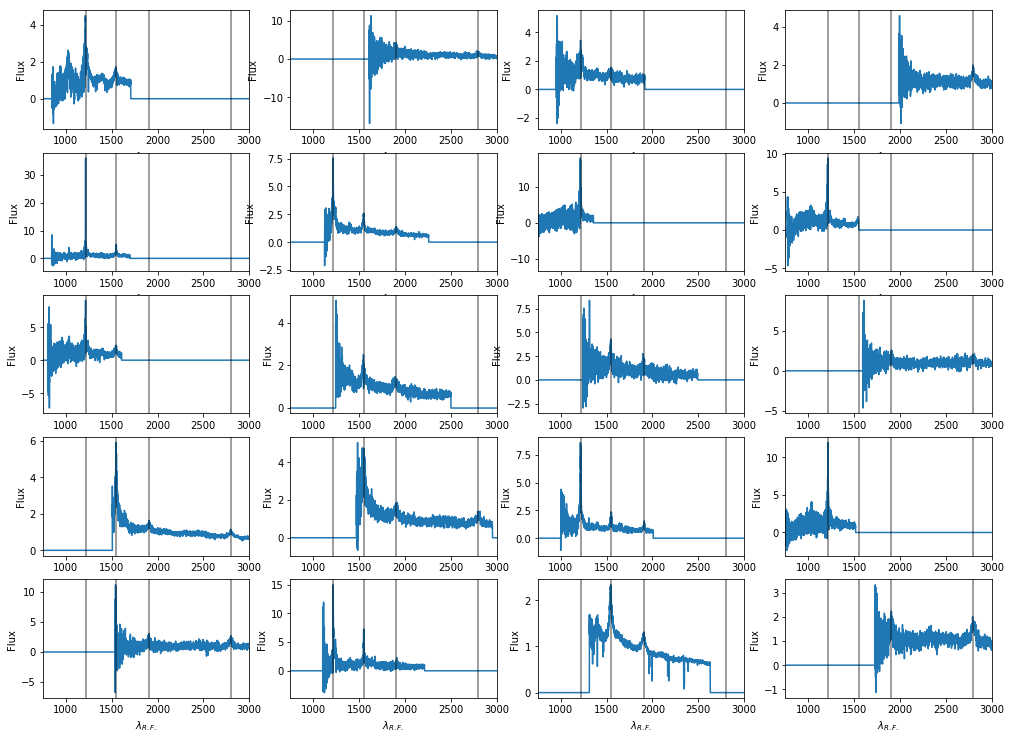

In [26]:
plt.figure(figsize=(17,65))
for i in range(len(flux_empca))[:20]:
    plt.subplot(25,4,i+1)
    plt.plot(wave_empca,flux_empca[i])
    axvline(1216,color='k',alpha=0.5) # I choose the point of Ly-alpha peak.
    axvline(1549,color='k',alpha=0.5)
    axvline(1906,color='k',alpha=0.5)
    axvline(2800,color='k',alpha=0.5)
    plt.xlabel('$\lambda_{R.F.}$', fontsize = 10)
    plt.ylabel('Flux', fontsize = 10)    
    plt.xlim(750,3000)

Now, I show the spectra with the output of empca, where each spectrum have the continuum. 

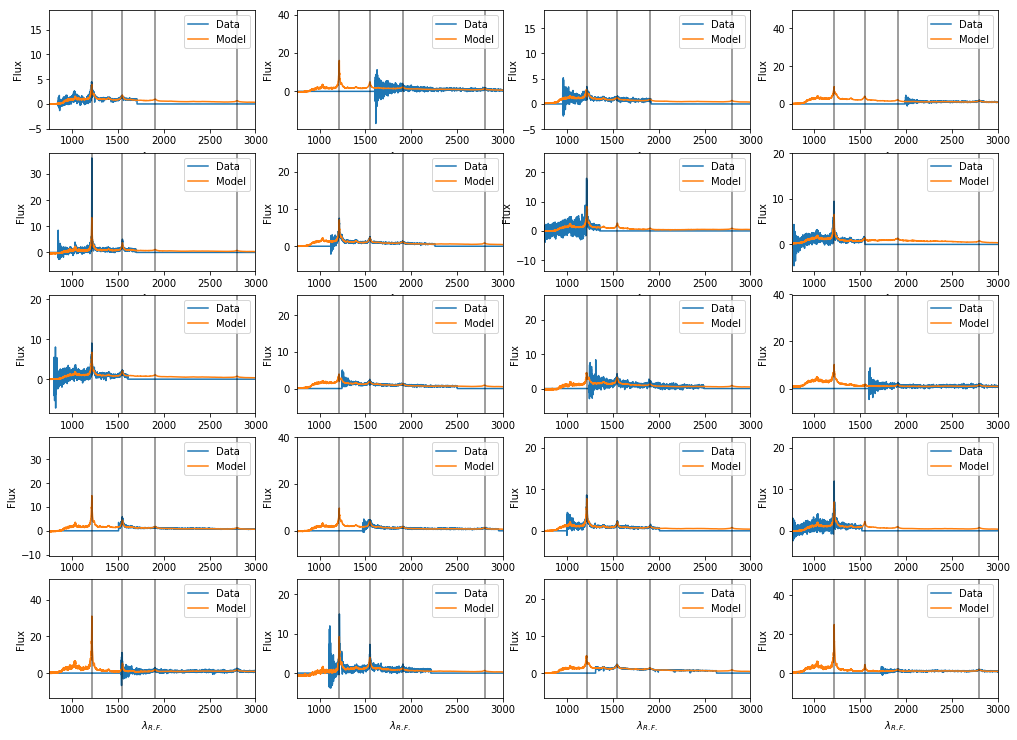

In [128]:
plt.figure(figsize=(17,65))
for j in range(len(model_empca.data))[:20]:
    plt.subplot(25,4,j+1)
    plt.plot(wave_empca,model_empca.data[j],label='Data')
    plt.plot(wave_empca,model_empca.model[j],label='Model')
    axvline(1216,color='k',alpha=0.5) # I choose the point of Ly-alpha peak.
    axvline(1549,color='k',alpha=0.5)
    axvline(1906,color='k',alpha=0.5)
    axvline(2800,color='k',alpha=0.5)
    plt.xlabel('$\lambda_{R.F.}$', fontsize = 10)
    plt.ylabel('Flux', fontsize = 10)
    plt.xlim(750,3000)
    #plt.ylim(-10,10)
    plt.legend()

Let's look the firts two eigenspectra.

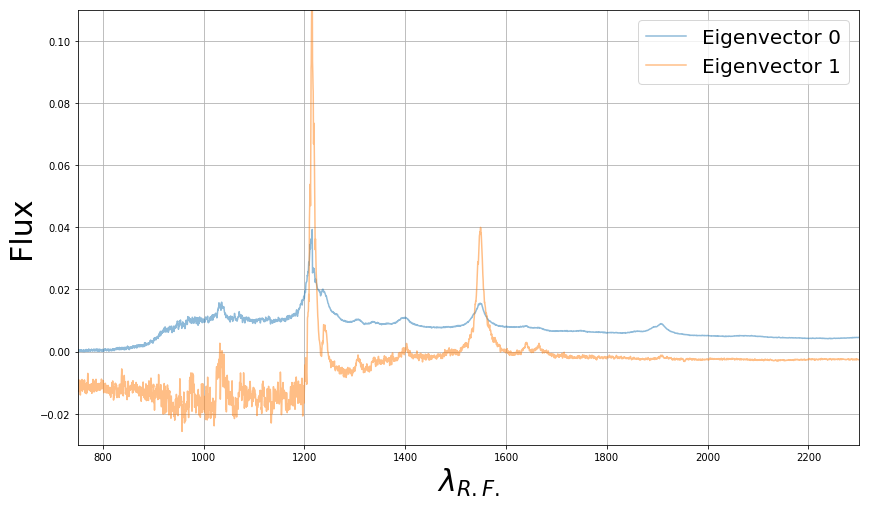

In [35]:
plt.figure(figsize=(14,8))
pylab.plot(wave_empca,model_empca.eigvec[0],label='Eigenvector 0',alpha=0.5)
pylab.plot(wave_empca,model_empca.eigvec[1],label='Eigenvector 1',alpha=0.5)
#axvline(1216,color='k',alpha=0.5)
plt.xlim(750,2300)
plt.ylim(-0.03,0.11)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 30)
plt.ylabel('Flux', fontsize = 30)
plt.grid()
plt.legend(fontsize = 20)

In [98]:
res = fitsio.FITS("EMPCA_BOSSDR14.fits",'rw')
res.write([wave_empca],names=['wavelength'])
res.write([flux_empca,ivar_empca,model_empca.model,model_empca.data,model_empca.weights],names=['flux','ivar','model','data','weights'])
res.write([model_empca.coeff],names=['coeff'])
res.write([model_empca.eigvec],names=['eigvec'])
#res.write([model_empca.nobs,model_empca.nvar,model_empca.nvec,model_empca.dof],names=['nobs','nvar','nvec','dof'])
#res.write([model_empca.R2,model_empca.R2vec,model_empca.chi2,model_empca.rchi2],names=['R2','R2vec','chi2','rchi2'])
#res.write([model_empca.set_data,model_empca.solve_coeffs,model_empca.solve_eigenvectors,model_empca.solve_model],names=['set_data','solve_coeff','solve_eigenvectors','solve_model'])
res.close()

# Mocks SIMQSO.

The next lines are only if one work in a local branch.

In [99]:
os.environ['PYTHONPATH']='/global/cscratch1/sd/rodcn25/desi/code/desisim/py:'+os.environ['PYTHONPATH']
os.environ['PATH']='/global/cscratch1/sd/rodcn25/desi/code/desisim/bin/:'+os.environ['PATH']

Let me start by analysing the SIMQSO mocks for to make empca. Let's need to use the restframe from the SIMQSO.

In [100]:
from desisim.templates import SIMQSO
simqso = SIMQSO(restframe=True)

Let's choose 1000 QSO spectra.

In [101]:
nqso = 1000
seed = 55
tflux, twave, tmeta, tmag = simqso.make_templates(nqso, seed=seed, zrange=(2, 4))
dw = 0.1
wave = np.arange(600, 10000, dw)
mask=(twave>550) & (twave <2000)

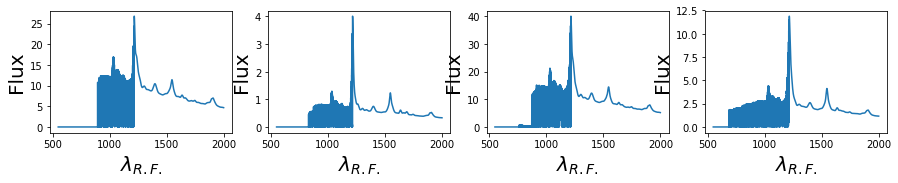

In [102]:
plt.figure(figsize=(15,13))
for i in range(nqso)[:4]:
    plt.subplot(5,4,i+1)
    flux=tflux[i]
    plt.plot(twave[mask],flux[mask])
    plt.xlabel('$\lambda_{R.F.}$',fontsize=20)
    plt.ylabel('Flux',fontsize=20)

In [103]:
qsoflux = np.zeros((nqso, wave.size))
for i in range(nqso):
    qsoflux[i] = resample_flux(wave, twave, tflux[i])

Normalizing the spectra.

In [104]:
for i in range(qsoflux.shape[0]):
    qsoflux[i] /= np.median(qsoflux[i])

Let's start the EMPCA for 4 eigenvector and 20 iterations.

In [105]:
model = empca.empca(qsoflux, niter=20, nvec=4)

       iter        R2             rchi2
EMPCA  1/20       0.00651180     19.06054751
EMPCA  2/20       0.92578084      1.08372662
EMPCA  3/20       0.92917570      1.02741676
EMPCA  4/20       0.92934984      1.02488882
EMPCA  5/20       0.92951213      1.02253436
EMPCA  6/20       0.92970120      1.01979162
EMPCA  7/20       0.92985157      1.01761026
EMPCA  8/20       0.92994542      1.01624927
EMPCA  9/20       0.92999679      1.01550452
EMPCA 10/20       0.93002310      1.01512343
EMPCA 11/20       0.93003613      1.01493480
EMPCA 12/20       0.93004249      1.01484294
EMPCA 13/20       0.93004556      1.01479856
EMPCA 14/20       0.93004705      1.01477719
EMPCA 15/20       0.93004777      1.01476692
EMPCA 16/20       0.93004811      1.01476200
EMPCA 17/20       0.93004828      1.01475963
EMPCA 18/20       0.93004836      1.01475850
EMPCA 19/20       0.93004840      1.01475795
EMPCA 20/20       0.93004842      1.01475769
R2: 0.930048443609


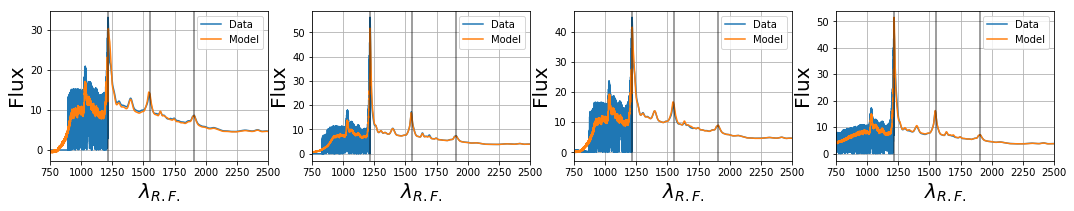

In [129]:
plt.figure(figsize=(18,16))
for i in range(nqso)[:4]:
    plt.subplot(5,4,i+1)
    pylab.plot(wave,model.data[i],label='Data')
    pylab.plot(wave,model.model[i], label='Model')
    axvline(1216,color='k',alpha=0.5) # I choose the point of Ly-alpha peak.
    axvline(1549,color='k',alpha=0.5)
    axvline(1906,color='k',alpha=0.5)
#    axvline(2800,color='k',alpha=0.5)
    plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
    plt.ylabel('Flux', fontsize = 20) 
    plt.xlim(750,2500)
    plt.grid()
    plt.legend()

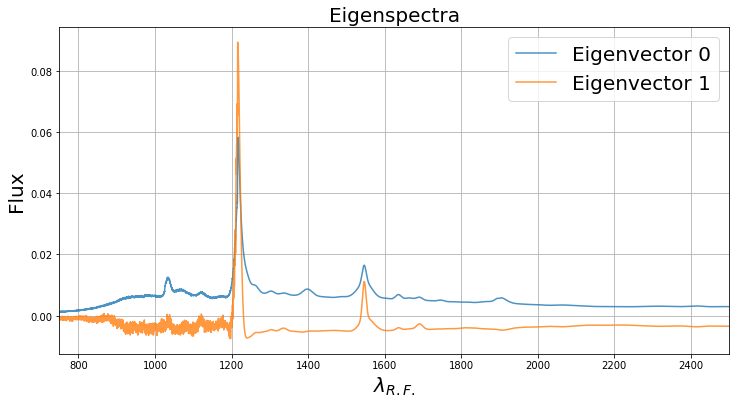

In [126]:
plt.figure(figsize=(12,6))
plt.title('Eigenspectra',fontsize=20)
pylab.plot(wave,model.eigvec[0], label='Eigenvector 0',alpha=0.8)
pylab.plot(wave,model.eigvec[1], label='Eigenvector 1',alpha=0.8)
#pylab.plot(model.eigvec[2], label='3 Eigenvector')
plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
plt.ylabel('Flux', fontsize = 20) 
plt.xlim(750,2500)
plt.grid()
plt.legend(fontsize=20)

In [127]:
mres = fitsio.FITS("EMPCA_SIMQSO.fits",'rw')
mres.write([wave],names=['wavelength'])
mres.write([qsoflux,model.model,model.data,model.weights],names=['flux','model','data','weights'])
mres.write([model.coeff],names=['coeff'])
mres.write([model.eigvec],names=['eigvec'])
#res.write([model_empca.nobs,model_empca.nvar,model_empca.nvec,model_empca.dof],names=['nobs','nvar','nvec','dof'])
#res.write([model_empca.R2,model_empca.R2vec,model_empca.chi2,model_empca.rchi2],names=['R2','R2vec','chi2','rchi2'])
#res.write([model_empca.set_data,model_empca.solve_coeffs,model_empca.solve_eigenvectors,model_empca.solve_model],names=['set_data','solve_coeff','solve_eigenvectors','solve_model'])
mres.close()

# Let's compare the eigenvectors between mocks and BOSS DR14 data.

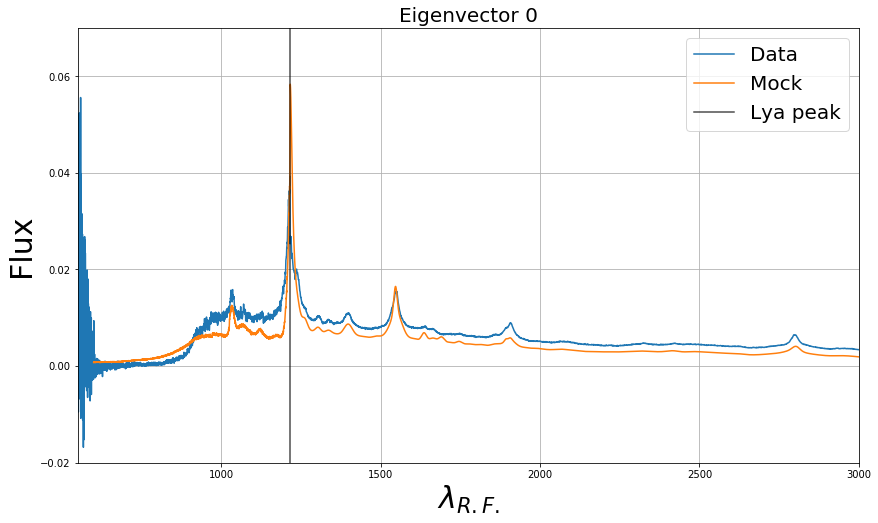

In [125]:
plt.figure(figsize=(14,8))
plt.title('Eigenvector 0',fontsize=20)
pylab.plot(wave_empca,model_empca.eigvec[0],label='Data')
pylab.plot(wave,model.eigvec[0], label='Mock')
axvline(1216,color='k', label='Lya peak', alpha=0.7)
plt.xlim(550,3000)
plt.ylim(-0.02,0.07)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 30)
plt.ylabel('Flux', fontsize = 30)
plt.grid()
plt.legend(fontsize = 20)
#plt.savefig('eigenspectra0_MD')

As in both cases the mean spectrum wasn't subtracted, the eigenvector 0 is similar to this one.

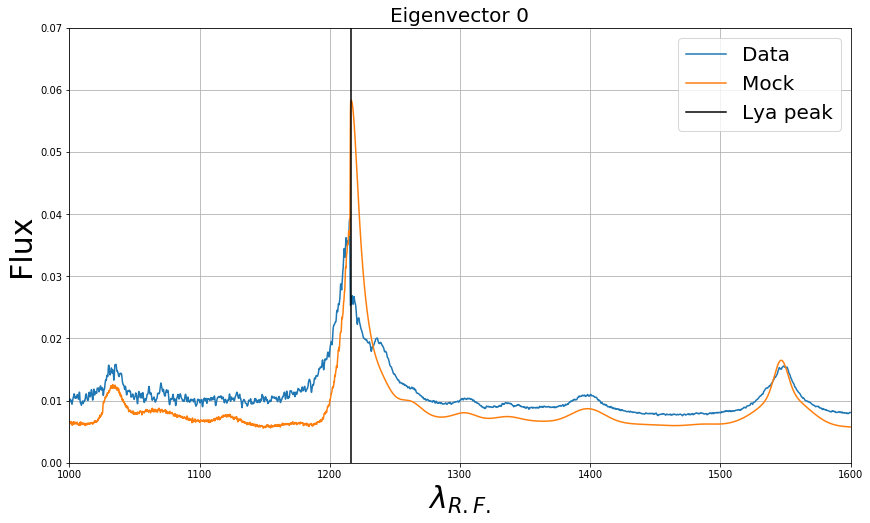

In [123]:
plt.figure(figsize=(14,8))
plt.title('Eigenvector 0',fontsize=20)
pylab.plot(wave_empca,model_empca.eigvec[0],label='Data')
pylab.plot(wave,model.eigvec[0], label='Mock')
axvline(1216,color='k', label='Lya peak')
plt.xlim(1000,1600)
plt.ylim(0,0.07)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 30)
plt.ylabel('Flux', fontsize = 30)
plt.grid()
plt.legend(fontsize = 20)
plt.savefig('eigenspectra0_MD_qso')

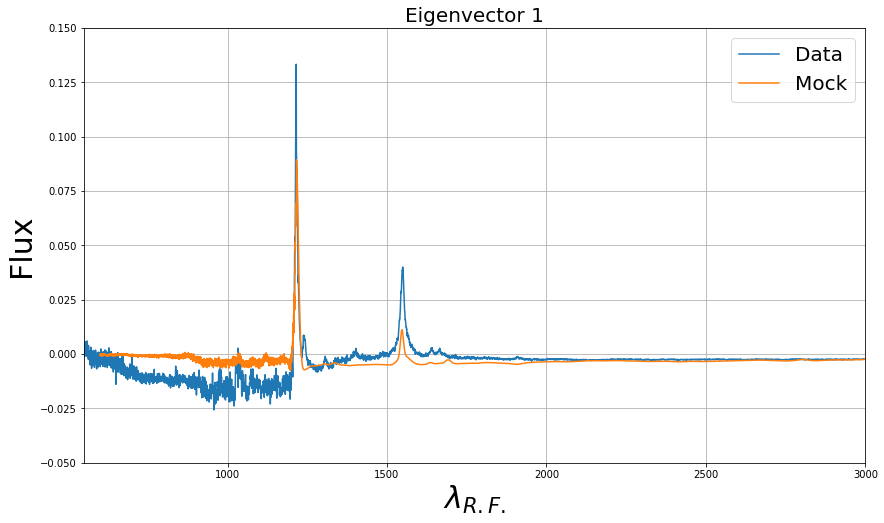

In [124]:
plt.figure(figsize=(14,8))
plt.title('Eigenvector 1',fontsize=20)
pylab.plot(wave_empca,model_empca.eigvec[1],label='Data')
pylab.plot(wave,model.eigvec[1], label='Mock')
#axvline(1216,color='k', label='Lya peak',alpha=0.5)
plt.xlim(550,3000)
plt.ylim(-0.05,0.15)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 30)
plt.ylabel('Flux', fontsize = 30)
plt.grid()
plt.legend(fontsize = 20)
plt.savefig('eigenspectra1_MD_qso')

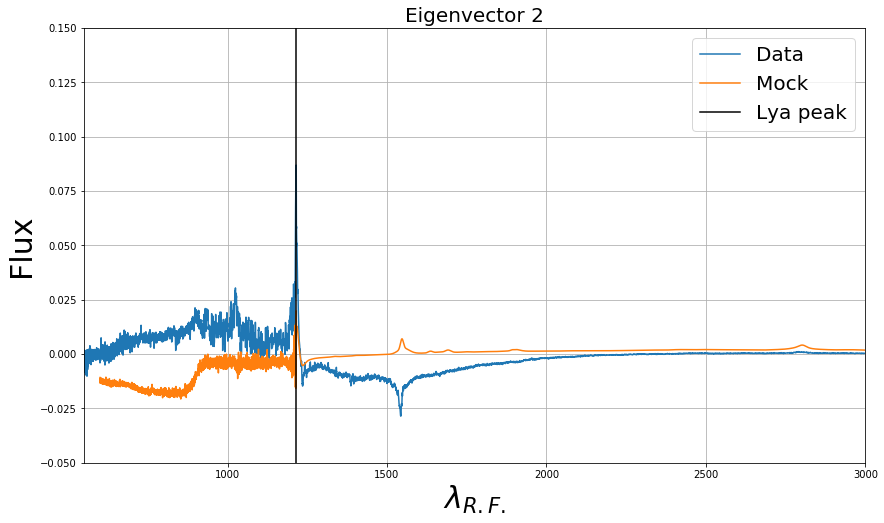

In [121]:
plt.figure(figsize=(14,8))
plt.title('Eigenvector 2',fontsize=20)
pylab.plot(wave_empca,model_empca.eigvec[2],label='Data')
pylab.plot(wave,model.eigvec[2], label='Mock')
axvline(1216,color='k', label='Lya peak')
plt.xlim(550,3000)
plt.ylim(-0.05,0.15)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 30)
plt.ylabel('Flux', fontsize = 30)
plt.grid()
plt.legend(fontsize = 20)
#plt.savefig('eigenspectra0_MD')

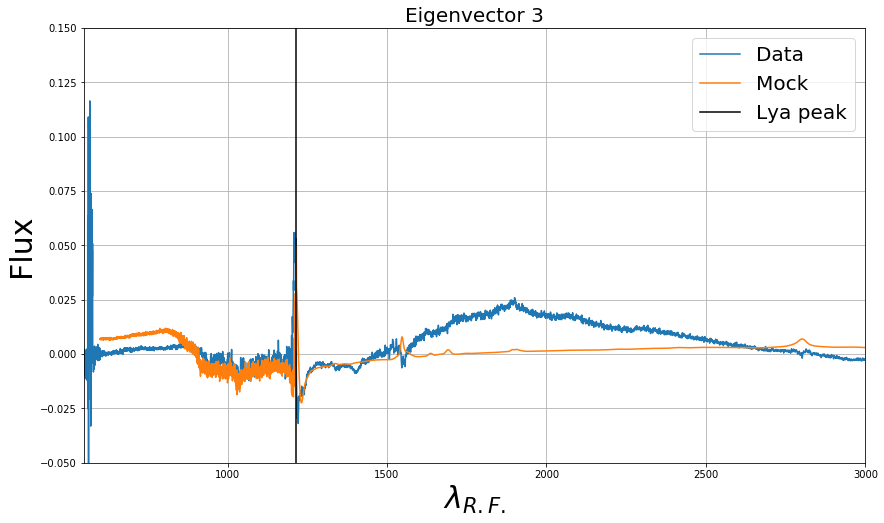

In [122]:
plt.figure(figsize=(14,8))
plt.title('Eigenvector 3',fontsize=20)
pylab.plot(wave_empca,model_empca.eigvec[3],label='Data')
pylab.plot(wave,model.eigvec[3], label='Mock')
axvline(1216,color='k', label='Lya peak')
plt.xlim(550,3000)
plt.ylim(-0.05,0.15)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 30)
plt.ylabel('Flux', fontsize = 30)
plt.grid()
plt.legend(fontsize = 20)
#plt.savefig('eigenspectra0_MD')